Link to download datasset
https://www.kaggle.com/datasets/ammarnassanalhajali/bccd-coco

In [4]:
# Part 1: Import Libraries and Functions for Data Loading

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from PIL import Image

# Step 1: Parse the annotations
def load_data_from_coco(folder_path):
    with open(os.path.join(folder_path, "_annotations.coco.json"), 'r') as f:
        annotations = json.load(f)
    
    categories = {cat['id']: cat['name'] for cat in annotations['categories']}
    images = annotations['images']
    annotations_data = annotations['annotations']
    
    image_label_map = {}
    for ann in annotations_data:
        image_id = ann['image_id']
        label = categories[ann['category_id']]
        image_name = next(img['file_name'] for img in images if img['id'] == image_id)
        image_label_map[os.path.join(folder_path, image_name)] = label
    
    return image_label_map


In [ ]:
# Part 2: Prepare the Dataset

def prepare_dataset(base_path):
    datasets = {}
    for folder in ['train', 'valid', 'test']:
        folder_path = os.path.join(base_path, folder)
        datasets[folder] = load_data_from_coco(folder_path)
    return datasets

# Main script
base_path = r"path to your dataset"
datasets = prepare_dataset(base_path)

# Step 3: Load images and labels
def load_images_and_labels(dataset):
    images, labels = [], []
    class_map = {}
    for i, (file_path, label) in enumerate(dataset.items()):
        img = Image.open(file_path).resize((128, 128))  # Resize to 128x128
        images.append(np.array(img) / 255.0)  # Normalize images
        if label not in class_map:
            class_map[label] = len(class_map)
        labels.append(class_map[label])
    return np.array(images), np.array(labels), class_map

# Load training, validation, and test datasets
train_images, train_labels, class_map = load_images_and_labels(datasets['train'])
valid_images, valid_labels, _ = load_images_and_labels(datasets['valid'])
test_images, test_labels, _ = load_images_and_labels(datasets['test'])

print("Number of training images:", len(train_images))
print("Number of validation images:", len(valid_images))
print("Number of testing images:", len(test_images))


Number of training images: 765
Number of validation images: 73
Number of testing images: 36


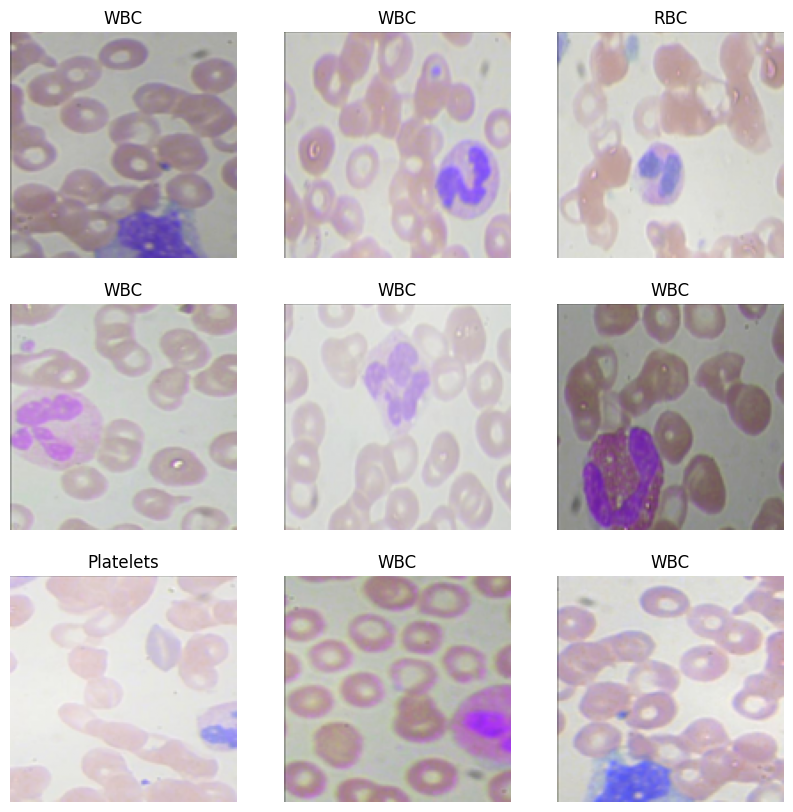

In [6]:
# Part 3: Display Samples

def display_samples(images, labels, class_map):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        idx = np.random.randint(len(images))
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(list(class_map.keys())[list(class_map.values()).index(labels[idx])])
        plt.axis("off")
    plt.show()

# Display some random samples from the training data
display_samples(train_images, train_labels, class_map)


In [7]:
# Part 4: Data Augmentation on the Fly

def augment_data_on_the_fly(train_images, train_labels):
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        rescale=1./255  # Rescale images
    )
    
    # Flow data with labels
    datagen_flow = datagen.flow(train_images, train_labels, batch_size=32)
    
    return datagen_flow


In [8]:
# Part 5: Build and Train CNN Model

def build_and_train_model(X_train, y_train, X_valid, y_valid, class_map, epochs=10):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_map), activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs)
    return model, history



Training without augmentation...


C:\Users\aasis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 277ms/step - accuracy: 0.4312 - loss: 1.6254 - val_accuracy: 0.1370 - val_loss: 1.3555
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5103 - loss: 1.0151 - val_accuracy: 0.1370 - val_loss: 1.2379
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.5182 - loss: 1.0054 - val_accuracy: 0.1370 - val_loss: 1.2069
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 239ms/step - accuracy: 0.5273 - loss: 0.9968 - val_accuracy: 0.1233 - val_loss: 1.3296
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 0.4948 - loss: 0.9693 - val_accuracy: 0.1370 - val_loss: 1.4455
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.5207 - loss: 0.9553 - val_accuracy: 0.1507 - val_loss: 1.5432
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 0.5646 - loss: 0.9198 - val_accuracy: 0.1644 - val_loss: 1.3770
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.5838 - loss: 0.8879 - val_accuracy: 0.

C:\Users\aasis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.4939 - loss: 1.0700 - val_accuracy: 0.1644 - val_loss: 1.4681
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.5234 - loss: 1.0167 - val_accuracy: 0.1644 - val_loss: 1.5248
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.5070 - loss: 1.0357 - val_accuracy: 0.1507 - val_loss: 1.4392
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 267ms/step - accuracy: 0.5275 - loss: 1.0342 - val_accuracy: 0.1370 - val_loss: 1.5745
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.5119 - loss: 1.0254 - val_accuracy: 0.1370 - val_loss: 1.5657
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 272ms/step - accuracy: 0.4971 - loss: 1.0460 - val_accuracy: 0.1370 - val_loss: 1.5456
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.5144 - loss: 1.0229 - val_accuracy: 0.1370 - val_loss: 1.5465
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.5117 - loss: 1.0341 - val_accuracy: 0.

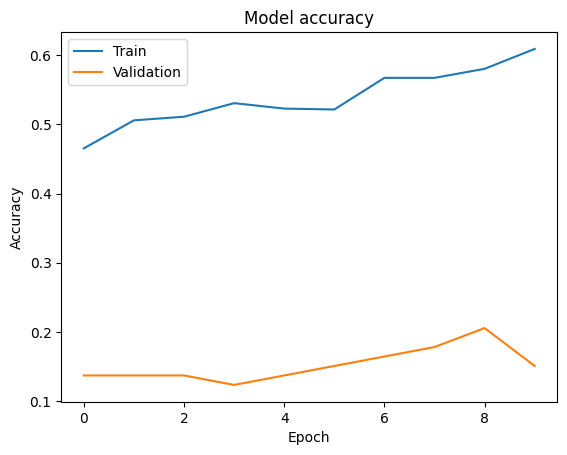

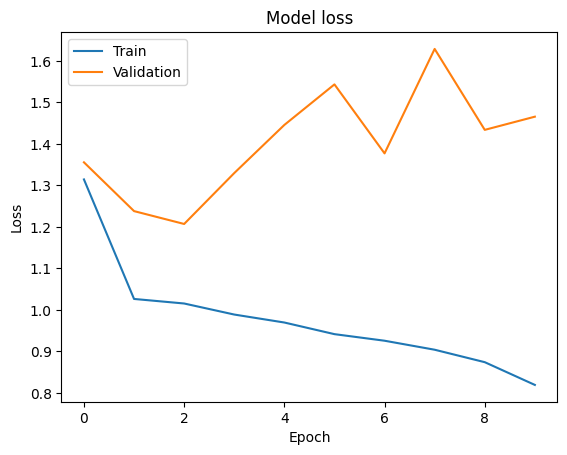


Plotting history for model with augmentation...


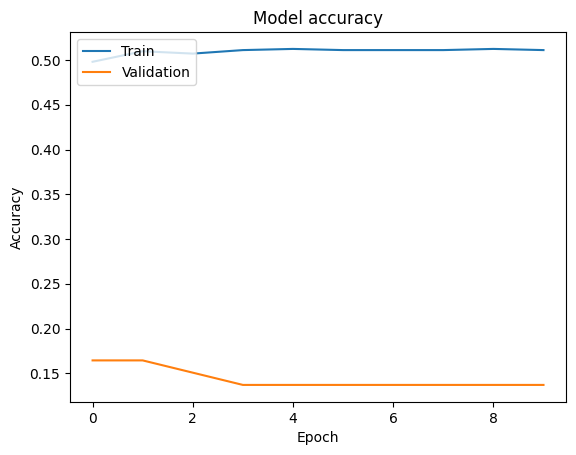

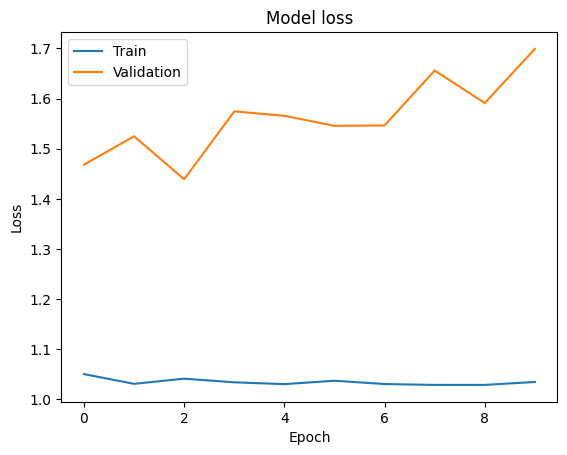

In [9]:
# Part 6: Training with Augmentation and Plotting

# Train the model without augmentation
print("\nTraining without augmentation...")
model_no_aug, history_no_aug = build_and_train_model(train_images, train_labels, valid_images, valid_labels, class_map)

# Augment data on the fly and train again
train_datagen_flow = augment_data_on_the_fly(train_images, train_labels)

print("\nTraining with augmentation...")
history_aug = model_no_aug.fit(train_datagen_flow, validation_data=(valid_images, valid_labels), epochs=10)

# Compare results
print("\nAccuracy without augmentation:", history_no_aug.history['val_accuracy'][-1])
print("Accuracy with augmentation:", history_aug.history['val_accuracy'][-1])

# Part 7: Plot Training History
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Plot training history for both models
print("\nPlotting history for model without augmentation...")
plot_history(history_no_aug)

print("\nPlotting history for model with augmentation...")
plot_history(history_aug)
